# Importing the Data

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 99

In [2]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

cars = pd.read_csv('imports-85.data', names=cols)

In [3]:
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [4]:
#Selecting only those columns that have continuous values
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

# Cleaning the Data

In [5]:
numeric_cars = numeric_cars.replace('?',np.nan)

In [6]:
numeric_cars = numeric_cars.astype(float)

In [7]:
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [8]:
# Since 'price' is the column we want to predict, we will remove any rows where the value for price is missing

numeric_cars.dropna(subset=['price'],inplace=True)

In [9]:
#For the rest of the missing values or null values, we will replace them with the column averages

numeric_cars.fillna(numeric_cars.mean(),inplace=True)

In [10]:
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [11]:
numeric_cars.shape

(201, 15)

In [12]:
#Normalizing all columns except the 'price' column
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.mean())/(numeric_cars.std())
numeric_cars['price'] = price_col
numeric_cars.head(5)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.000000,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,0.075201,0.519597,-1.825369,-0.290709,0.203476,-0.245942,-0.650624,-0.540937,13495.0
1,0.000000,-1.680910,-0.438315,-0.851335,-2.029015,-0.014821,0.075201,0.519597,-1.825369,-0.290709,0.203476,-0.245942,-0.650624,-0.540937,16500.0
2,0.000000,-0.708334,-0.243544,-0.185134,-0.558319,0.516789,0.604724,-2.427374,0.674254,-0.290709,1.354267,-0.245942,-0.961995,-0.687669,16500.0
3,1.312654,0.165335,0.194690,0.147966,0.217881,-0.422710,-0.430252,-0.524899,0.452769,-0.041019,-0.037387,0.799836,-0.183569,-0.100741,13950.0
4,1.312654,0.099398,0.194690,0.243137,0.217881,0.518722,0.219617,-0.524899,0.452769,-0.540399,0.310527,0.799836,-1.117680,-1.274597,17450.0


# Building Machine Learning Models

## Univariate KNN

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [14]:
#Creating a function to train and test univartiate KNN models using values of 1,3,5,7,9 for k

def knn_train_test(train_col,test_col,df):
    #Ensuring the results can be replicated later
    np.random.seed(1)
    
    #Shuffling the order of the dataframe for hygiene purposes
    df = df.iloc[np.random.permutation(len(df))]
    
    #Separating the main dataframe into training and test sets
    train_df = df.iloc[:int(len(df)*0.5)]
    test_df = df.iloc[int(len(df)*0.5):]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
    
    #Training the KNN model and returning the RMSE error metric for the predicted values
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]],train_df[test_col])
        predictions = knn.predict(test_df[[train_col]])
        mse = mean_squared_error(test_df[test_col], predictions)
        rmse = mse ** 0.5
        k_rmses[k] = rmse
        
    return k_rmses

In [15]:
#Let us repeat the above process using every numeric column for training individually

train_cols = numeric_cars.columns.drop('price')

k_rmse_results = {}
for col in train_cols:
    rmse_vals = knn_train_test(col,'price', numeric_cars)
    k_rmse_results[col] = rmse_vals

In [16]:
k_rmse_results

{'normalized-losses': {1: 7779.606037519503,
  3: 7480.692360872743,
  5: 7337.2848203845515,
  7: 7795.000930504562,
  9: 7705.82454665913},
 'wheel-base': {1: 4493.734068810494,
  3: 5120.161506064513,
  5: 5461.490335934409,
  7: 5448.173408324034,
  9: 5738.621574471594},
 'length': {1: 4577.003915399697,
  3: 5087.460276710444,
  5: 5429.644739577333,
  7: 5307.702178308323,
  9: 5383.054514833446},
 'width': {1: 4559.257297950061,
  3: 4606.421075087697,
  5: 4772.510209128695,
  7: 4715.979827895643,
  9: 4736.091903473983},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8132.467731772246,
  7: 7704.344964170201,
  9: 7779.56469282989},
 'curb-weight': {1: 5288.0195725810245,
  3: 5011.8789151002,
  5: 4453.680702653493,
  7: 4330.149364501495,
  9: 4632.92525121302},
 'engine-size': {1: 3227.659787364569,
  3: 2946.7417879781224,
  5: 3297.6997444813674,
  7: 3563.43509928404,
  9: 3831.764970642862},
 'bore': {1: 8602.58848450066,
  3: 6977.123411794459,
  5: 67

**Visualizing RMSE for Different Values of K**

Text(0, 0.5, 'RMSE')

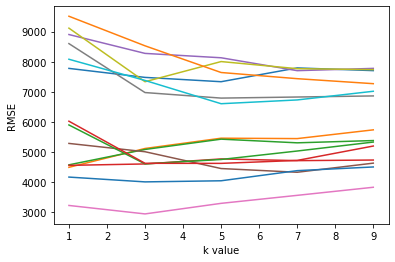

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x,y,label="{}".format(k))

plt.xlabel('k value')
plt.ylabel('RMSE')


## Multivariate KNN

In [18]:
# Computing the average RMSE for each feature across the different k values
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

engine-size          3373.460278
horsepower           4223.530357
width                4678.052063
curb-weight          4743.330761
highway-mpg          5040.509230
city-mpg             5126.515991
length               5156.973125
wheel-base           5252.436179
compression-rate     7164.249800
bore                 7213.387243
normalized-losses    7619.681739
stroke               7993.732370
peak-rpm             8078.822375
height               8159.606698
dtype: float64


In [19]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomizing order of rows in data frame
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Dividing number of rows in half
    last_train_row = int(len(rand_df) / 2)
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fitting model using KNN
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        predicted_labels = knn.predict(test_df[train_cols])
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {5: 2938.1306900277887},
 '3 best features': {5: 3576.5381752208214},
 '4 best features': {5: 3435.145837075945},
 '5 best features': {5: 3457.4725012114936},
 '6 best features': {5: 3415.73077323836}}

## Hyperparameter Optimization

In [20]:
# We will now try and optimize the values of k for the models that performed the best in the previous step

def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomizing order of rows in dataframe
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Dividing number of rows in half 
    last_train_row = int(len(rand_df) / 2)
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fitting model using KNN
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])
        predicted_labels = knn.predict(test_df[train_cols])
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {1: 2824.8287076781794,
  2: 2615.442453055988,
  3: 2676.6521480521455,
  4: 2831.7841198370656,
  5: 2938.1306900277887,
  6: 3128.516968715745,
  7: 3204.0554389097565,
  8: 3459.8826047221833,
  9: 3715.847780310613,
  10: 3980.307424292901,
  11: 4151.348212046468,
  12: 4231.233582321214,
  13: 4321.751665703992,
  14: 4366.489859575597,
  15: 4487.120412964203,
  16: 4591.609216968047,
  17: 4683.284404125849,
  18: 4739.084337496269,
  19: 4784.099214347852,
  20: 4777.706746763483,
  21: 4816.3918959481325,
  22: 4806.480777296786,
  23: 4832.819314595003,
  24: 4883.724636768665},
 '3 best features': {1: 3384.9422637192606,
  2: 3261.939437825234,
  3: 3142.577321948092,
  4: 3306.01101075266,
  5: 3576.5381752208214,
  6: 3709.4813226235947,
  7: 3610.411169953427,
  8: 3694.9374649086276,
  9: 3848.9692035290686,
  10: 3973.5807329145964,
  11: 4098.883214686969,
  12: 4217.8064717212055,
  13: 4298.670431349281,
  14: 4313.880284852934,
  15: 4276.18876

## Visualizing above data

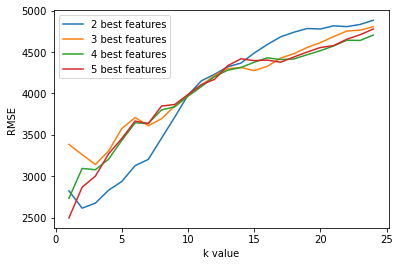

In [21]:
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())  
    plt.plot(x,y, label="{}".format(k))
    
plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend()